In [73]:
#!/usr/bin/env python
import argparse
import os
import numpy as np
import pandas as pd
import nibabel as nb

from alleninf.api import get_probes_from_genes,\
    get_expression_values_from_probe_ids, get_mni_coordinates_from_wells
from alleninf.data import get_values_at_locations, combine_expression_values
from alleninf.analysis import fixed_effects, approximate_random_effects,\
    bayesian_random_effects

stat_map  = '/Users/kanaan/SCR/workspace/tmp/randomise_tfce_p_tstat1.nii.gz'
gene_name = 'FTL'


# Clardy, et.al. (2006). Acute and chronic effects of developmental iron deficiency 
# on mRNA expression patterns in the brain. Journal of Neural Transmission, 71, 173–96. 
# http://www.ncbi.nlm.nih.gov/pubmed/17447428

up_regulated_genes = {
                    'ALOX12'     :  'arachidonate 12-lipoxygenase',
                    'ETFDH'      :  'electron-transferring-flavoprotein dehydrogenase',
                    'TFRC'       :  'transferrin receptor',
                    #'LOC59322', :  'membrane-associated guanylate kinase-interacting protein',
                    #'Tubb5'     :  'tubulin, beta 5'
                    'ACTA2'      :  'actin, alpha 2, smooth muscle, aorta',
                    'CAT'        :  'Catalase',
                    #'CDC2a'     :  'cell division cycle 2 homolog A (S. pombe)',
                    'HMGB2'      :  'High mobility group box 2',
                    'GNB1'       :  'Guanine nucleotide binding protein (G protein), beta polypeptide 1',
                    #'---'       :  'Rat mRNA for beta-tubulin T beta15'
                    'TOP2a'      :  'topoisomerase (DNA) II alpha' ,
                    'SLC11A2'    :  'Solute carrier family 11 , member 2 (proton-coupled divalent metal ion transporters)',
                    'FKBP1B'     :  'FK506 binding protein 1B, 12.6 kDa',
                    #'---'       :  'Rattus norvegicus similar to Myristoylated alanine-rich C-kinase substrate (MARCKS), mRNA',
                    #'---'       #  'Rattus norvegicus similar to protein ref (H.sapiens) KIAA0275 gene product',
                    'COL1A1'     :  'collagen, type 1, alpha 1',
                    'LOC286978'  :  'thymosin beta-like protein', 
                    'CD48'       :  'CD48 antigen',
                    'GCH1'       :  'GTP cyclohydrolase 1',
                    'SLC16A1'    :  'Solute carrier family 16, member 1',
                    'ALAS2'      :  'aminolevulinate, delta-, synthase 2', 
                    'KDR'        :  'kinase insert domain receptor (a type III receptor tyrosine kinase)',
                    'CIRBP'      :  'cold inducible RNA binding protein',
                    'CSAD'       :  'cysteine sulfinic acid decarboxylase', 
                   }

down_regulated_genes = { 
                    'THRSP'      :  'thyroid hormone responsive protein',
                    #''          :  'Rattus norvegicus Nclone10 mRNA',
                    'TF'         :  'transferrin',
                    'MAL'        :  'mal, T-cell differentiation protein',
                    'KLK6'       :  'kallikrein-related peptidase 6', 
                    'HOMER1'     :  'homer homolog 1 (Drosophila), neuronal immediate early gene',
                    'MOBP'       :  'myelin-associated oligodendrocytic basic protein',
                    'APOD'       :  'apolipoprotein D',
                    #''          :  'Rat troponin-c mRNA'
                    'MOG'        :  'myelin oligodendrocyte glycoprotein',
                    'CRYAB'      :  'crystallin, alpha B',
                    #'Af6'       :  'afadin',
                    ''           :  'Rattus norvegicus retroviral-like ovarian specific transcript 30-1 mRNA',
                    'APOC1'      :  'apolipoprotein C-I',
                    'CA2'        :  'carbonic anhydrase II',
                    'RASGRP1'    :  'RAS guanyl releasing protein 1',
                    'STMN4'      :  'stathmin-like 4',
                    'Rnf28'      :  'ring finger protein 28',
                    'Lyz'        :  'lysozyme', 
                    #'LOC309574' :  'olfactory receptor',
                    'GSTM1'      :  'glutathione S-transferase mu 1', 
                    'CTSS'       :  'cathepsin S', 
                    'DCK'        :  'deoxycytidine kinase',
                    #''           :  'Rattus norvegicus similar to S-100 protein, alpha chain (LOC295214), mRNA',
                    #''           :  'Rat PMSG-induced ovarian mRNA, 3’sequence, N1'
                       }

In [74]:
print "Fetching probe ids for gene %s" % gene_name
probes_dict = get_probes_from_genes(gene_name)
print "Found %s probes: %s" % (len(probes_dict), ", ".join(probes_dict.values()))


Fetching probe ids for gene FTL
Found 5 probes: CUST_4420_PI416261804, A_32_P158433, A_23_P50498, A_32_P155247, A_23_P50504


In [75]:
print "Fetching expression values for probes %s" % (", ".join(probes_dict.values()))
expression_values, well_ids, donor_names = get_expression_values_from_probe_ids(
    probes_dict.keys())
print "Found data from %s wells sampled across %s donors" % (len(well_ids), len(set(donor_names)))


Fetching expression values for probes CUST_4420_PI416261804, A_32_P158433, A_23_P50498, A_32_P155247, A_23_P50504
Found data from 3702 wells sampled across 6 donors


In [76]:
print "Combining information from selected probes"
combined_expression_values = combine_expression_values(
    expression_values, method='pca')


Combining information from selected probes


In [77]:
print "Translating locations of the wells to MNI space"
mni_coordinates = get_mni_coordinates_from_wells(well_ids)

Translating locations of the wells to MNI space


In [78]:
nifti_values = get_values_at_locations(
        stat_map, mni_coordinates, radius=3, verbose=True, 
        mask_file = '/usr/local/fsl/data/atlases/Striatum/striatum-structural-1mm.nii.gz'
        )

In [79]:
# preparing the data frame
names = ["NIFTI values", "%s expression" % gene_name, "donor ID"]
data = pd.DataFrame(np.array(
    [nifti_values, combined_expression_values, donor_names]).T, columns=names)
data = data.convert_objects(convert_numeric=True)
len_before = len(data)
data.dropna(axis=0, inplace=True)
nans = len_before - len(data)

/Users/kanaan/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  """


Pearson correlation between NIFTI values and FTL expression across all donors is 0.285372 (two tailed p value = 9.64637e-06)


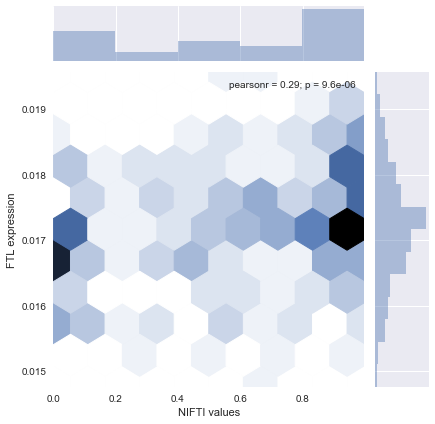

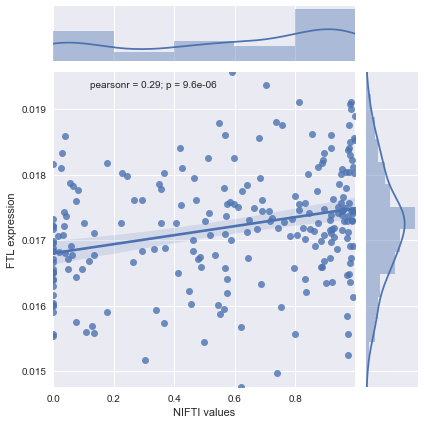

(0.28537225617501399, 9.6463666241377942e-06)

In [80]:
%matplotlib inline
fixed_effects(data, ["NIFTI values", "%s expression" % gene_name])